# 2010 Analysis with Clustering methods

## Goal
My objective with this notebook is to analyze brazilian cities data related to 2010 measurements using the follows clustering methods:
- KMeans Clustering
- PCA (Principal Components Analysis)
- t-SNE

For this purpose, I want to understand a specific target variable: **IDHM**. The main idea is to answer this question:
### "Based in 2010 numeric measurements, it's possible to clusterize our data into IDHM categories?"

The IDHM 2010 categories mencioned are listed bellow:
![IDHM2010](https://user-images.githubusercontent.com/32513366/71258991-2843b500-2316-11ea-9ba2-46541647ad5a.PNG)

Where, from left to the right, IDHM have those categories:
- C1: from **0** to **0,499**
- C2: from **0,500** to **0,599**
- C3: from **0,600** to **0,699**
- C4: from **0,700** to **0,799**
- C5: from **0,800** to **1**

For more info, acess [here](http://www.atlasbrasil.org.br/2013/pt/o_atlas/idhm/). So now let's begin!

## Common Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1 - Import and Select the data
For this analysis,as was said I will use the numeric columns related to measures of 2010 in Brazil cities. 

In [2]:
# Import data with pandas
df = pd.read_csv('../input/brazilian-cities/BRAZIL_CITIES.csv',delimiter=';')
# Select our columns based in 2010 measures
desired_cols = list(df.columns[0:16]) + list(df.columns[19:25])
df = df[desired_cols]

In [3]:
# Preview
df.head(3)

,CITY,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,...,IBGE_5-9,IBGE_10-14,IBGE_15-59,IBGE_60+,IDHM,IDHM_Renda,IDHM_Longevidade,IDHM_Educacao,LONG,LAT
0,Abadia De Goiás,GO,0,6876.0,6876.0,0.0,2137.0,1546.0,591.0,5300.0,...,438.0,517.0,3542.0,416.0,0.708,0.687,0.830,0.622,-49.440548,-16.758812
1,Abadia Dos Dourados,MG,0,6704.0,6704.0,0.0,2328.0,1481.0,847.0,4154.0,...,260.0,351.0,2709.0,589.0,0.690,0.693,0.839,0.563,-47.396832,-18.487565
2,Abadiânia,GO,0,15757.0,15609.0,148.0,4655.0,3233.0,1422.0,10656.0,...,894.0,1087.0,6896.0,990.0,0.690,0.671,0.841,0.579,-48.718812,-16.182672


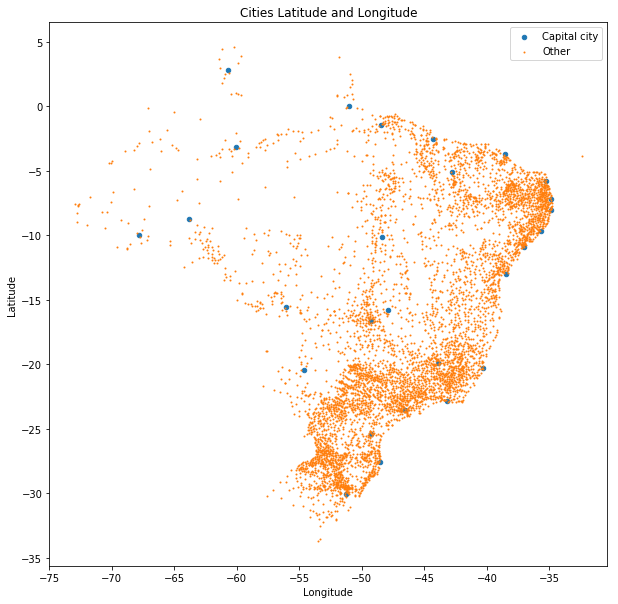

In [4]:
# Plot a Brazil map based in LAT/LON
## remove zero values
mask1= df["LONG"] != 0
mask2 = df["LAT"] !=0 
mask3 = df['CAPITAL'] ==1
 
## use the scatter function
plt.figure(figsize=(10,10))
plt.title("Cities Latitude and Longitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.scatter(df[mask1&mask2&mask3]["LONG"], df[mask1&mask2&mask3]["LAT"], s=20, alpha=1, label='Capital city')
plt.scatter(df[mask1&mask2&~mask3]["LONG"], df[mask1&mask2&~mask3]["LAT"], s=1, alpha=1, label='Other')
plt.legend()
plt.show()

This plot was based on other [notebook](https://www.kaggle.com/fjab76/brazilian-cities-a-simple-exploration) for this same dataset. Through this figure, it is possible to see that the **data density** is close to the coastal region in southern, southeastern and northeast areas.

# 2 - Creating IDHM Categories
Using the categories presented before, I will create manually IDHM categories for the data

In [5]:
# Loop into all samples to create the categories
for i in range(0, len(df)):
    # Category 1
    if df.loc[i,'IDHM'] >= 0.0 and df.loc[i,'IDHM'] < 0.500:
        df.loc[i,'IDHM_CAT'] = 'C1'
    # Category 2
    elif df.loc[i,'IDHM'] >= 0.500 and df.loc[i,'IDHM'] < 0.600:
        df.loc[i,'IDHM_CAT'] = 'C2'
    # Category 3
    elif df.loc[i,'IDHM'] >= 0.600 and df.loc[i,'IDHM'] < 0.700:
        df.loc[i,'IDHM_CAT'] = 'C3'
    # Category 4
    elif df.loc[i,'IDHM'] >= 0.700 and df.loc[i,'IDHM'] < 0.800:
        df.loc[i,'IDHM_CAT'] = 'C4'
    # Category 5
    elif df.loc[i,'IDHM'] >= 0.800 and df.loc[i,'IDHM'] <= 1:
        df.loc[i,'IDHM_CAT'] = 'C5'

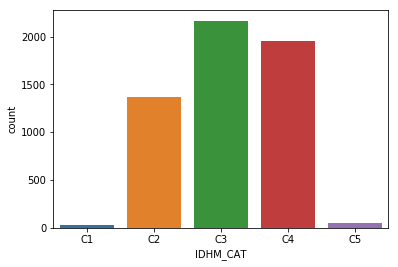

In [6]:
# Barplot
sns.countplot(x="IDHM_CAT", data=df, order=['C1','C2','C3','C4','C5']);

As you can see, our categories are desbalanced for **C1** and   **C5** and this could be a problem for our models. To future analysis, I will create another column, now mixing together **C1** with **C2** and **C4** with **C5**.

In [7]:
# Loop into all samples to create the categories more balanced
for i in range(0, len(df)):
    # Category 1 and 2
    if df.loc[i,'IDHM'] >= 0.0 and df.loc[i,'IDHM'] < 0.600:
        df.loc[i,'IDHM_CAT2'] = 'C1-C2'
    # Category 3
    elif df.loc[i,'IDHM'] >= 0.600 and df.loc[i,'IDHM'] < 0.700:
        df.loc[i,'IDHM_CAT2'] = 'C3'
    # Category 4
    elif df.loc[i,'IDHM'] >= 0.700 and df.loc[i,'IDHM'] <= 1:
        df.loc[i,'IDHM_CAT2'] = 'C4-C5'

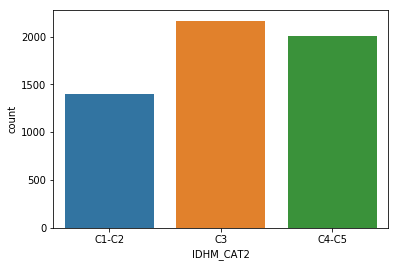

In [8]:
# Barplot
sns.countplot(x="IDHM_CAT2", data=df, order=['C1-C2','C3','C4-C5']);

Now we have a more balanced class for IDHM. To simplify our life, I will work with the second kind of categories that is more balanced.

# 3 - Missing data treament
For this notebook, I will **only** work with complete samples and focus in my clustering analysis. So I will remove any sample that contains a missing value.

In [9]:
# See how many NaN values do I have
df.isnull().sum()

CITY                  0
STATE                 0
CAPITAL               0
IBGE_RES_POP          8
IBGE_RES_POP_BRAS     8
IBGE_RES_POP_ESTR     8
IBGE_DU              10
IBGE_DU_URBAN        10
IBGE_DU_RURAL        81
IBGE_POP              8
IBGE_1                8
IBGE_1-4              8
IBGE_5-9              8
IBGE_10-14            8
IBGE_15-59            8
IBGE_60+              8
IDHM                  8
IDHM_Renda            8
IDHM_Longevidade      8
IDHM_Educacao         8
LONG                  9
LAT                   9
IDHM_CAT              8
IDHM_CAT2             8
dtype: int64

In [10]:
# How many rows do I have now?
sb = len(df)
sb

5573

In [11]:
# Drop any row that contains a single NaN value
df.dropna(axis=0, inplace=True)

In [12]:
# Reset index
df.index = range(0,len(df))

In [13]:
# How many rows do I have after cleaning my dataset?
sa = len(df)
sa

5490

In [14]:
# What I have lost?
sb - sa

83

So, after I cleaned my dataset I lost 83 samples. When I choose such a simple strategy, I assume that those samples will not be meaningful for my study. Other ways for Data imputation could be applied, but I chose not to do so since the loss was quite insignificant (1.5% of my data was lost).

# 4 - Split X and Y
In this short part, I will split our data into X (predictors) and Y (target).

In [15]:
# Separate y categorical (targets)
y = df[['IDHM_CAT2']]
yReal = df[['IDHM_CAT']]
# Separate y numeric
yNum = df[['IDHM']]
# Separate x (predictors)
x = df[['IBGE_RES_POP', 'IBGE_RES_POP_BRAS','IBGE_RES_POP_ESTR', 'IBGE_DU', 'IBGE_DU_URBAN', 'IBGE_DU_RURAL', 'IBGE_POP', 
        'IBGE_1', 'IBGE_1-4', 'IBGE_5-9', 'IBGE_10-14', 'IBGE_15-59', 'IBGE_60+']]
# Separate a (analysis)
a = df[['CITY', 'STATE', 'CAPITAL', 'LONG', 'LAT']]

## 5 - Data Standardization
Because our predictors data have different ranges, I will apply a standardization using *sklearn* to get a comparable range for our variables. 

This is important because most of the clustering methods are based in *distance metrics* such as KMeans and PCA. So an unique range it's necessary to make all variables comparable, avoiding those mistakes:

**|X - Y| = 100000**

**|Y - Z| = 0.1**

Based only in a scale difference.

**PS**: I could use Normalization method, but this way is sensible to outliers so I will stick to standardization.

In [16]:
# Import sklearn preprocessing library
from sklearn.preprocessing import StandardScaler

In [17]:
# Create MinMaxScaler object
normData = StandardScaler()

In [18]:
# Scale our x set by applying a fit and transform
nd_x = normData.fit_transform(x)

In [19]:
# Transform the results into a dataframe as was the original
x = pd.DataFrame(nd_x, index=x.index, columns=x.columns)

# 5 - Correlation Analysis
Before we jump in our models creation, I will do a correlation analysis into our X set. This analysis will help see correlated information between our variables and could help to improve our results later.

In [20]:
# Spearman correlation
mc = x.corr(method='spearman')

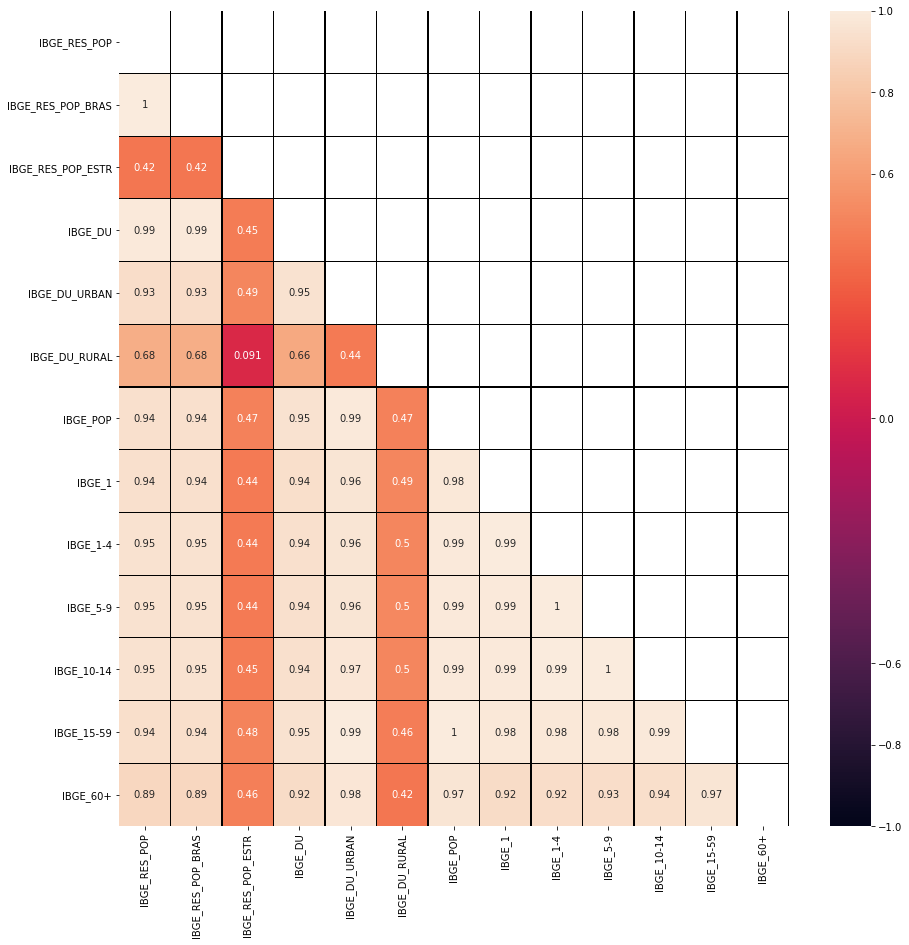

In [21]:
# Generate a mask for the upper triangle
triangle_mask = np.zeros_like(mc, dtype=np.bool)
triangle_mask[np.triu_indices_from(triangle_mask)] = True

# Plot
plt.figure(figsize = (15,15))
sns.heatmap(data = mc, linewidths=.1, linecolor='black', vmin = -1, vmax = 1, mask = triangle_mask, annot = True,
            cbar_kws={"ticks":[-1,-0.8,-0.6,0,0.6,0.8,1]});

Through the heatmap analysis, we can see that, indeed, there is a high correlation in our predictors set.

# 6 - K-Means clustering

The main idea to use KMeans here, is to visualize clusters based on our IDHM categories. **However**, we have a high dimensional data in predictors set (13 variables) which makes it impossible to create a reasonable plot (the maximum is a 3D plot). So to this task I will implement a feature selection before the model creation to choose the best variables to create the clusters and visualize. 

### 6.1 - Feature selection with SKlearn for two variables

In [22]:
# Import the libraries to FS and score function (metric)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [23]:
# FS process for only two predictors variables
FS2 = SelectKBest(score_func=mutual_info_classif, k=2);

In [24]:
# Fit and Transform
x_fs2 = FS2.fit_transform(x, y.values.ravel());

In [25]:
# The chosen 2 variables
fs2_cols = x.columns[FS2.get_support()]
fs2_cols

Index(['IBGE_RES_POP_ESTR', 'IBGE_DU_URBAN'], dtype='object')

### 6.2 - Feature selection with SKlearn for three variables

In [26]:
# FS process for three predictors variables
FS3 = SelectKBest(score_func=mutual_info_classif, k=3);

In [27]:
# Fit and Transform
x_fs3 = FS3.fit_transform(x, y.values.ravel());

In [28]:
# The chosen 3 variables
fs3_cols = x.columns[FS3.get_support()]
fs3_cols

Index(['IBGE_RES_POP_ESTR', 'IBGE_DU_URBAN', 'IBGE_60+'], dtype='object')

### 6.3 - KMeans for two variables

In [29]:
# Import our favorite library
from sklearn.cluster import KMeans

In [30]:
# Create our data variable
train = x[fs2_cols]

In [31]:
# Elbow Method for K-Means
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=1206)
    km.fit(train)
    distortions.append(km.inertia_)

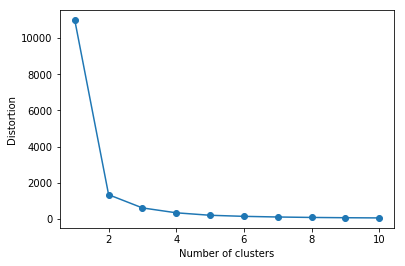

In [32]:
# plot Elbow
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Apparently by the elbow method (way to choose the K optimal), 3 clusters could be a good decision using 2 variables.

In [33]:
# Creating KMeans model with 3 clusters as was propose
km3 = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=1206)

In [34]:
# Fit/Predict KMeans 3 Cluster
pred2D = km3.fit_predict(train);

In [35]:
# Create auxiliar dataframe for plot
data = pd.concat([train, y], axis=1)

In [36]:
# Create a column for predicted clusters from KMeans
for i in range(0,len(data)):
    if pred2D[i] == 0:
        data.loc[i,'PREDICT'] = 'Cluster 1'
    elif pred2D[i] == 1:
        data.loc[i,'PREDICT'] = 'Cluster 2'
    elif pred2D[i] == 2:
        data.loc[i,'PREDICT'] = 'Cluster 3'

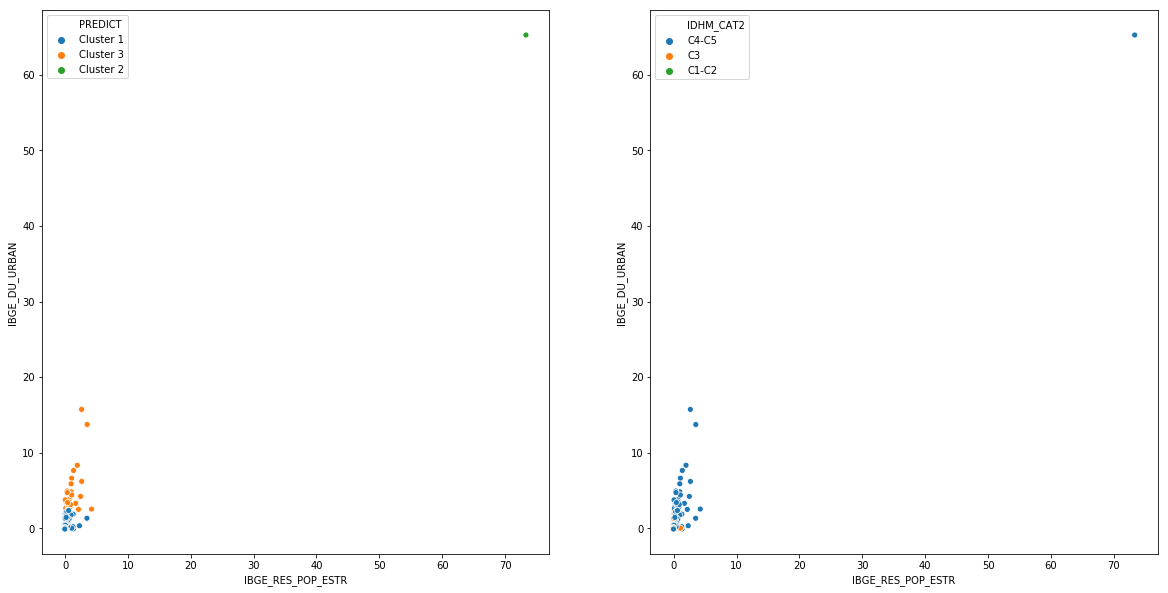

In [37]:
# Plot 2D
fig, ax = plt.subplots(1,2, figsize=(20,10));
sns.scatterplot(x='IBGE_RES_POP_ESTR', y='IBGE_DU_URBAN', hue="PREDICT", data=data, ax=ax[0], sizes=0.1);
sns.scatterplot(x='IBGE_RES_POP_ESTR', y='IBGE_DU_URBAN', hue="IDHM_CAT2", data=data, ax=ax[1]);

Through this plot we can see that KMeans with two features, based on my pipeline, was succesfull to clusterize our data, but the real data doesn't show to a clear clusterization. Therefore the clusters created by KMeans can lead to mistakes. We will see if with 3 variables there can be a clearer grouping.

### 6.4 - KMeans for three variables

In [38]:
# Create our data variable
train = x[fs3_cols]

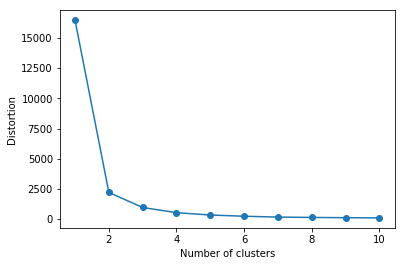

In [39]:
# Elbow Method for K-Means
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=1206)
    km.fit(train)
    distortions.append(km.inertia_)
# plot Elbow
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Now, using three variables shows that distortion did not changed at all.

In [40]:
# Creating KMeans model with 3 clusters as was propose
km3 = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=1206)

In [41]:
# Fit/Predict KMeans 3 Cluster
pred3D = km3.fit_predict(train);

In [42]:
# Create auxiliar dataframe for plot
data = pd.concat([train, y], axis=1)

In [43]:
# Create a column for predicted clusters from KMeans
for i in range(0,len(data)):
    if pred2D[i] == 0:
        data.loc[i,'PREDICT'] = 'Cluster 1'
        #data.loc[i,'COLOR'] = 'blue'
    elif pred2D[i] == 1:
        data.loc[i,'PREDICT'] = 'Cluster 2'
        #data.loc[i,'COLOR'] = 'green'
    elif pred2D[i] == 2:
        data.loc[i,'PREDICT'] = 'Cluster 3'
        #data.loc[i,'COLOR'] = 'orange'

In [44]:
# Import library for 3D plot
import plotly.express as px

In [45]:
# Plot 3D - Original Variables Cluster
px.scatter_3d(data, x='IBGE_DU_URBAN', y='IBGE_RES_POP_ESTR', z='IBGE_60+', color='IDHM_CAT2')

In [46]:
# Plot 3D - Original Variables Cluster
px.scatter_3d(data, x='IBGE_DU_URBAN', y='IBGE_RES_POP_ESTR', z='IBGE_60+', color='PREDICT')

## other way to plot
# Library for 3D
#from mpl_toolkits.mplot3d import Axes3D
# Plot 3D
#plotting = plt.figure(figsize=(15,15)).gca(projection='3d');
#plotting.scatter(data['IBGE_DU_URBAN'], data['IBGE_RES_POP_ESTR'], data['IBGE_60+'],c=data['COLOR']);
#plotting.set_xlabel('IBGE_DU_URBAN');
#plotting.set_ylabel('IBGE_RES_POP_ESTR');
#plotting.set_zlabel('IBGE_60+');

So, based on those plots it is possible to see that KMeans creates succesfully the 3 clusters, but analyzing the real clusters with the data we can see that KMeans would probably predict wrong, most because the difference between IDHM categories are very blur.

By this, we can say that KMeans was unsucessful for this task.

# 7 - PCA
To use PCA, is not necessary a Feature selection (for a higher dimensional data it is recommended).

In [47]:
# Import our model
from sklearn.decomposition import PCA

## 7.1 - Using two Principal Components

In [48]:
# Create model
pca = PCA(n_components=2)

In [49]:
# Fit and Transform X to PC dimension
pc = pca.fit_transform(x)

In [50]:
# See explained variance
pca.explained_variance_ratio_

array([0.91401449, 0.06929645])

As is possible to see, our explained variance is very low. That could be a bad indicator for PCA in this dataset.

In [51]:
# Create a Dataframe for PC with target var
xPC = pd.DataFrame(data = pc, columns = ['PC1', 'PC2'])
# Join with target categories
xPC = pd.concat([xPC, y], axis = 1)

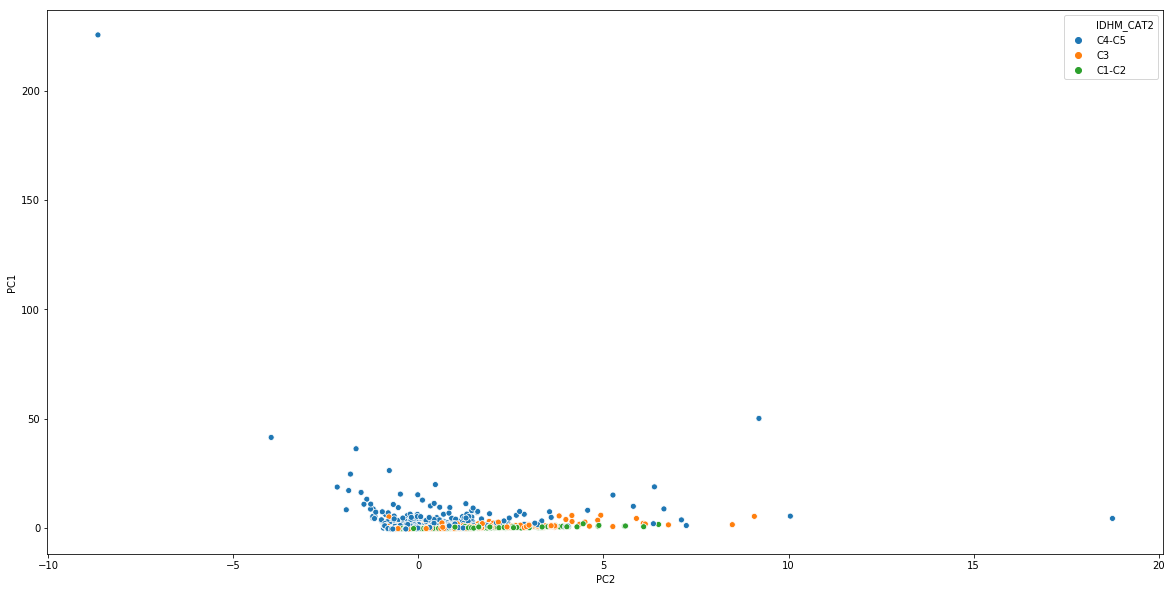

In [52]:
# Plot 2D
plt.figure(figsize=(20,10));
sns.scatterplot(x="PC2", y="PC1", hue="IDHM_CAT2", data=xPC);

So, through this plot we can see that using PCA with two components was unsuccessful. Now, let's see if a third dimension could improve the results.

### 7.2 - Using three Principal Components

In [53]:
# Create model
pca = PCA(n_components=3)

In [54]:
# Fit and Transform X to PC dimension
pc = pca.fit_transform(x)

In [55]:
# Create a Dataframe for PC with target var
xPC = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3'])
# Join with target categories
xPC = pd.concat([xPC, y], axis = 1)

In [56]:
# Plot 3D
px.scatter_3d(xPC, x='PC1', y='PC2', z='PC3', color='IDHM_CAT2')

In [57]:
# See explained variance
pca.explained_variance_ratio_

array([0.91401449, 0.06929645, 0.01381187])

Again, our PCA model has not succeed to visualize and separate in proper clusters. The explained variance could be a indicator for this mistake.

# 8 - tSNE

After the lost of KMeans and PCA, let's use a t-SNE to see if it is possible to clusterize our data based on 2010 measures.

In [58]:
# Import library for TSNE
from sklearn.manifold import TSNE

## tSNE with 2 components (2D plot)

In [59]:
# Create tSNE model
tsne = TSNE(n_components=2)

In [60]:
# Fit and Transform x
x_emb = tsne.fit_transform(x)

In [61]:
# Turn X embeddeb into a dataframe to a easy plot
x_emb = pd.DataFrame(data = x_emb, columns = ['XE1', 'XE2'])
# Join with target categories
x_emb = pd.concat([x_emb, y], axis = 1)

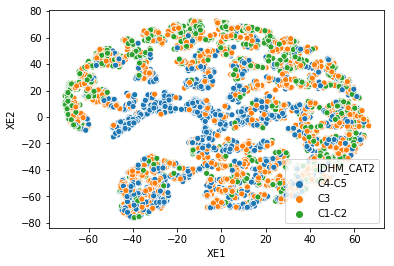

In [62]:
# Plot 2D data
sns.scatterplot(x='XE1', y='XE2', hue="IDHM_CAT2", data=x_emb);

## tSNE with 3 components (3D plot)

In [63]:
# Create tSNE model
tsne = TSNE(n_components=3)

In [64]:
# Fit and Transform x
x_emb = tsne.fit_transform(x)

In [65]:
# Turn X embedded into a dataframe to an easy plot
x_emb = pd.DataFrame(data = x_emb, columns = ['XE1', 'XE2', 'XE3'])
# Join with target categories
x_emb = pd.concat([x_emb, y], axis = 1)

In [66]:
# Plot 3D
px.scatter_3d(x_emb, x='XE1', y='XE2', z='XE3', color='IDHM_CAT2')

So, even for tSNE we did not had success to answer the question propose at *Goal*.

# Conclusions
With this notebook, we could see that not every machine learning story can end with a happy ending. Based in the question, we did not had sucess to apply correct clusters for IDHM. That is tons of possibilities for this failing:
- The hyperparameters was not set correctly for any method
- The correlated nature from predictors set could be real problem
- My feature selection for KMeans was not the best (most related with the first reason)
- The 2010 measurements used as predictors could not extract any information from IDHM

Using my experience, I could say that the third reason is correct. Sometimes the data can not give to us the desired answer. Besides that, it is important to remember that the methods used here are **Unsupervised** methods, meaning that they were blinded to our target (IDHM categories).

**PS**: The first possibility still reasonable.

So, answering the beginning question:

### No, the 2010 numeric measurements do not hold enough (or any) knowledge about IDHM categories, making impossible to clusterize.